# MÓDULO 32 - Random Forest


Nesta tarefa, vocês vão trabalhar com uma base de dados de avaliações de vinhos, onde o objetivo é prever a pontuação dos vinhos usando o algoritmo de Random Forest para classificação multiclasse.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [25]:
df = pd.read_csv("winequality-red.csv", delimiter=',')
df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


**Características dos Vinhos (Features)**
- `Fixed Acidity`: Acidez fixa do vinho.
- `Volatile Acidity`: Acidez volátil do vinho.
- `Citric Acid`: Quantidade de ácido cítrico no vinho.
- `Residual Sugar`: Açúcar residual presente no vinho.
- `Chlorides`: Nível de cloretos no vinho.
- `Free Sulfur Dioxide`: Dióxido de enxofre livre no vinho.
- `Total Sulfur Dioxide`: Quantidade total de dióxido de enxofre no vinho.
- `Density`: Densidade do vinho.
- `pH`: Nível de pH do vinho.
- `Sulphates`: Quantidade de sulfatos no vinho.
- `Alcohol`: Teor alcoólico do vinho.

**Variável de Saída (Target):**
- `Quality`: Pontuação do vinho baseada em dados sensoriais, variando de 0 a 10.


Esta abordagem permitirá que vocês explorem como diferentes características químicas influenciam a qualidade dos vinhos e como o Random Forest pode ser usado para fazer previsões precisas com base nesses dados.

## 1 - Realize a primeira etapa de pré processamento dos dados.

### A) Verifique os tipos de dados.


In [26]:
df.columns = df.columns.str.upper()
df.columns = df.columns.str.replace(' ', '_')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   FIXED_ACIDITY         1599 non-null   float64
 1   VOLATILE_ACIDITY      1599 non-null   float64
 2   CITRIC_ACID           1599 non-null   float64
 3   RESIDUAL_SUGAR        1599 non-null   float64
 4   CHLORIDES             1599 non-null   float64
 5   FREE_SULFUR_DIOXIDE   1599 non-null   float64
 6   TOTAL_SULFUR_DIOXIDE  1599 non-null   float64
 7   DENSITY               1599 non-null   float64
 8   PH                    1599 non-null   float64
 9   SULPHATES             1599 non-null   float64
 10  ALCOHOL               1599 non-null   float64
 11  QUALITY               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


Os tipos de dados estão corretos.

### B) Verifique os dados faltantes, se houver dados faltantes faça a substituição ou remoção justificando sua escolha.

In [27]:
df.isnull().mean() * 100

FIXED_ACIDITY           0.0
VOLATILE_ACIDITY        0.0
CITRIC_ACID             0.0
RESIDUAL_SUGAR          0.0
CHLORIDES               0.0
FREE_SULFUR_DIOXIDE     0.0
TOTAL_SULFUR_DIOXIDE    0.0
DENSITY                 0.0
PH                      0.0
SULPHATES               0.0
ALCOHOL                 0.0
QUALITY                 0.0
dtype: float64

Não há dados faltantes. Não é necessário tratamento.

## 2 - Realize a segunda e terceita etapa de pré processamento dos dados.

### A) Utilize a função describe para identificarmos outliers e verificarmos a distribuição dos dados.

In [28]:
df.describe().round(3)

,FIXED_ACIDITY,VOLATILE_ACIDITY,CITRIC_ACID,RESIDUAL_SUGAR,CHLORIDES,FREE_SULFUR_DIOXIDE,TOTAL_SULFUR_DIOXIDE,DENSITY,PH,SULPHATES,ALCOHOL,QUALITY
count,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000,1599.000
mean,8.320,0.528,0.271,2.539,0.087,15.875,46.468,0.997,3.311,0.658,10.423,5.636
std,1.741,0.179,0.195,1.410,0.047,10.460,32.895,0.002,0.154,0.170,1.066,0.808
min,4.600,0.120,0.000,0.900,0.012,1.000,6.000,0.990,2.740,0.330,8.400,3.000
25%,7.100,0.390,0.090,1.900,0.070,7.000,22.000,0.996,3.210,0.550,9.500,5.000
50%,7.900,0.520,0.260,2.200,0.079,14.000,38.000,0.997,3.310,0.620,10.200,6.000
75%,9.200,0.640,0.420,2.600,0.090,21.000,62.000,0.998,3.400,0.730,11.100,6.000
max,15.900,1.580,1.000,15.500,0.611,72.000,289.000,1.004,4.010,2.000,14.900,8.000


### B) Verifique o balanceamento da váriavel Target.

In [29]:
df['QUALITY'].value_counts()

QUALITY
5    681
6    638
7    199
4     53
8     18
3     10
Name: count, dtype: int64

A partir da análise da variável Target, podemos perceber que o modelo está muito desbalanceado. Temos uma quantidade de valores mais elevada nas qualidade classificadas como 5 e 6, enquanto nas notas de 3, 4 e 8, temos quantidades muito pequenas. Por terem quantidades muito pequenas, temos que o modelo pode ser comprometido para a classificação das qualidades das notas citadas. 

### C)  Plote o gráfico ou a tabela e indique as variáveis que te parecem mais "fortes" na correlação para nosso modelo.

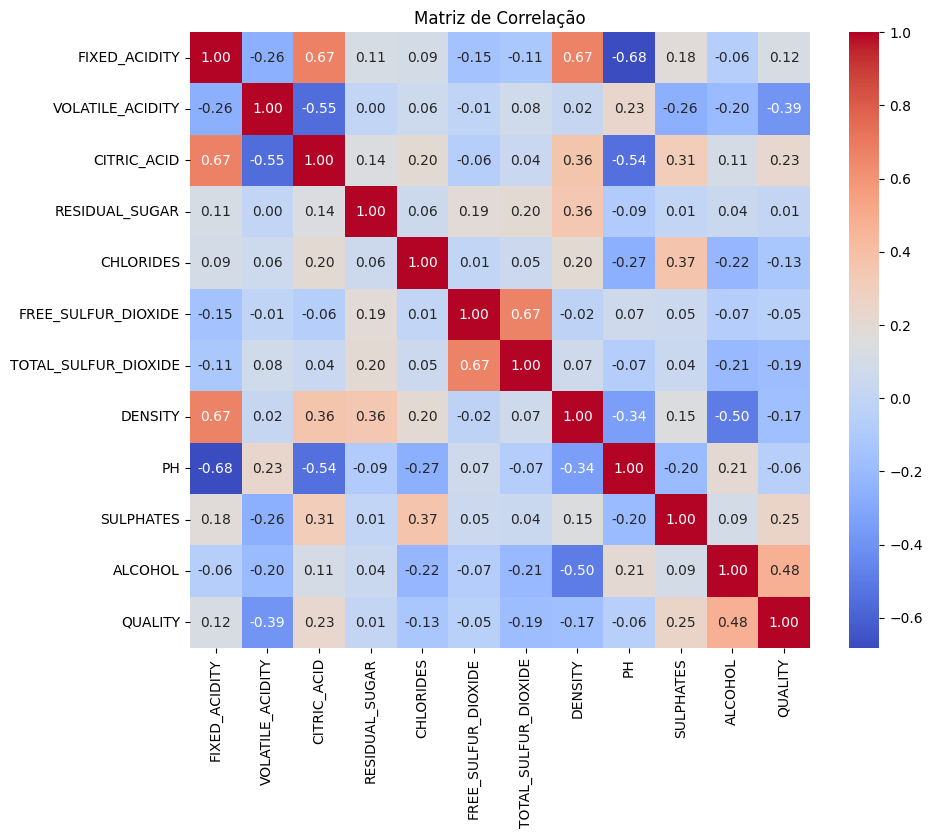

In [30]:
correlation_matrix = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10})
plt.title('Matriz de Correlação')
plt.show()

A partir da imagem acima, podemos ver que as cinco variáveis que possuem correlação (negativa ou positiva) mais forte com a variável TARGET, são:
1. `ALCOHOL`: +0.48
2. `VOLATILE_ACIDITY`: -0.39
3. `SULPHATES`: +0.25
4. `CITRIC_ACID`: 0.23
5. `TOTAL_SULFUR DIOXIDE`: -0.19

### D) Crie um novo dataframe apenas com as váriaveis que parecem ter maior correlação com a target. (Negativa ou positiva)

In [31]:
df_reduzido = df[['ALCOHOL', 'VOLATILE_ACIDITY', 'SULPHATES', 'CITRIC_ACID', 'TOTAL_SULFUR_DIOXIDE', 'QUALITY']]

## 3 - Preparação Final dos Dados

### A) Separe a base em X(Features) e Y(Target) e separe a base em treino e teste.


In [32]:
x_train, x_test, y_train, y_test = train_test_split(df_reduzido.drop('QUALITY', axis=1), df_reduzido['QUALITY'], test_size=0.20, random_state=0)

## 4 - Modelagem

### A) Inicie e treine o modelo de Random Forest


In [33]:
random_forest = RandomForestClassifier(random_state=0)
random_forest.fit(x_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

### B) Aplique a base de teste o modelo.

In [34]:
y_pred = random_forest.predict(x_test)

## 5 - Avaliação

### A) Avalie as principais métricas da Claissificação e traga insights acerca do resultado, interprete os valores achados.

In [35]:
print("RELATÓRIO DE CLASSIFICAÇÃO - MODELO REDUZIDO")
print(classification_report(y_test, y_pred))

RELATÓRIO DE CLASSIFICAÇÃO - MODELO REDUZIDO
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.74      0.81      0.78       135
           6       0.74      0.70      0.72       142
           7       0.49      0.63      0.55        27
           8       0.00      0.00      0.00         3

    accuracy                           0.71       320
   macro avg       0.33      0.36      0.34       320
weighted avg       0.68      0.71      0.69       320



/home/zocyus/Documents/EBAC/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/zocyus/Documents/EBAC/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/zocyus/Documents/EBAC/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

### B) Você nota que o modelo teve dificuldade para prever alguma classe? Se sim, acredita que tenha relação com o balanceamento dos dados? Explique.

Assim como mencionado anteriormente, pelo fato de terem poucos dados nas qualidade de nota 3, 4 e 8, o modelo não conseguiu realizar previsão destes, levando assim a uma precisão nula. A partir daqui, eliminaremos essas variáveis para ter um tratamento de dados mais adequado e preciso com as variáveis presentes em maior quantidade

In [36]:
df_reduzido = df_reduzido[~df_reduzido['QUALITY'].isin([3, 4, 8])]

x_train, x_test, y_train, y_test = train_test_split(df_reduzido.drop('QUALITY', axis=1), df_reduzido['QUALITY'], test_size=0.20, random_state=0)
random_forest = RandomForestClassifier(random_state=0)
random_forest.fit(x_train, y_train)

y_pred = random_forest.predict(x_test)
y_pred_train = random_forest.predict(x_train)


print("RELATÓRIO DE CLASSIFICAÇÃO (TREINO)")
print(classification_report(y_train, y_pred_train))


print("RELATÓRIO DE CLASSIFICAÇÃO (TESTE)")
print(classification_report(y_test, y_pred))

RELATÓRIO DE CLASSIFICAÇÃO (TREINO)
              precision    recall  f1-score   support

           5       1.00      1.00      1.00       539
           6       1.00      1.00      1.00       514
           7       1.00      1.00      1.00       161

    accuracy                           1.00      1214
   macro avg       1.00      1.00      1.00      1214
weighted avg       1.00      1.00      1.00      1214

RELATÓRIO DE CLASSIFICAÇÃO (TESTE)
              precision    recall  f1-score   support

           5       0.78      0.77      0.78       142
           6       0.65      0.72      0.68       124
           7       0.75      0.55      0.64        38

    accuracy                           0.72       304
   macro avg       0.73      0.68      0.70       304
weighted avg       0.73      0.72      0.72       304



Podemos notar um overfitting nos dados de treino, para contornar, antes de mexer nos hyperparâmetros, vamos eliminar duas colunas com menor relação com a variável TARGET.

In [37]:
df_reduzido = df_reduzido.drop(['TOTAL_SULFUR_DIOXIDE', 'CITRIC_ACID'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(df_reduzido.drop('QUALITY', axis=1), df_reduzido['QUALITY'], test_size=0.20, random_state=0)
random_forest = RandomForestClassifier(random_state=0)
random_forest.fit(x_train, y_train)

y_pred = random_forest.predict(x_test)
y_pred_train = random_forest.predict(x_train)


print("RELATÓRIO DE CLASSIFICAÇÃO (TREINO)")
print(classification_report(y_train, y_pred_train))


print("RELATÓRIO DE CLASSIFICAÇÃO (TESTE)")
print(classification_report(y_test, y_pred))

RELATÓRIO DE CLASSIFICAÇÃO (TREINO)
              precision    recall  f1-score   support

           5       0.99      1.00      0.99       539
           6       1.00      0.99      1.00       514
           7       0.99      1.00      1.00       161

    accuracy                           1.00      1214
   macro avg       0.99      1.00      1.00      1214
weighted avg       1.00      1.00      1.00      1214

RELATÓRIO DE CLASSIFICAÇÃO (TESTE)
              precision    recall  f1-score   support

           5       0.75      0.75      0.75       142
           6       0.64      0.69      0.66       124
           7       0.77      0.61      0.68        38

    accuracy                           0.70       304
   macro avg       0.72      0.68      0.70       304
weighted avg       0.71      0.70      0.70       304



O overfitting ainda persiste. Apesar disso, podemos notar que houve uma leve diminuição nas variáveis com maior volume de dados ('5' e '6') e um leve aumento na variável '7', o que indica um bom sinal.

## 6 - Melhorando os Hyperparametros

### A) Defina o Grid de parametros que você quer testar

In [38]:
param_grid_reduzido = {
    'n_estimators': [200, 250, 300],
    'max_depth': [5, 6, 7, 8, 9],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [4, 5, 6, 7],
    'criterion': ['gini', 'entropy']
}

### B) Inicie e Treine um novo modelo utilizando o random search.

In [39]:
random_search = RandomizedSearchCV(estimator=random_forest, param_distributions=param_grid_reduzido, n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=0, scoring='accuracy')
random_search.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...andom_state=0)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'criterion': ['gini', 'entropy'], 'max_depth': [5, 6, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [3, 4], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",100
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here...

In [40]:
best_rf_model = random_search.best_estimator_
best_rf_model.fit(x_train, y_train)
y_pred_otim = best_rf_model.predict(x_test)
y_pred_train_otim = best_rf_model.predict(x_train)

### C) Avalie os resultados do modelo.

In [41]:
print("RESULTADOS DO MODELO REDUZIDO OTIMIZADO (TREINO)")
print(classification_report(y_train, y_pred_train_otim))

print("\nRESULTADOS DO MODELO REDUZIDO OTIMIZADO (TESTE)")
print(classification_report(y_test, y_pred_otim))

RESULTADOS DO MODELO REDUZIDO OTIMIZADO (TREINO)
              precision    recall  f1-score   support

           5       0.82      0.88      0.85       539
           6       0.78      0.79      0.78       514
           7       0.83      0.57      0.68       161

    accuracy                           0.80      1214
   macro avg       0.81      0.75      0.77      1214
weighted avg       0.80      0.80      0.80      1214


RESULTADOS DO MODELO REDUZIDO OTIMIZADO (TESTE)
              precision    recall  f1-score   support

           5       0.74      0.71      0.72       142
           6       0.58      0.68      0.62       124
           7       0.68      0.39      0.50        38

    accuracy                           0.66       304
   macro avg       0.67      0.59      0.62       304
weighted avg       0.67      0.66      0.66       304



### D) Você identificou melhorias no modelo após aplicar o random search? Justifique.

Conseguimos retirar o overfitting do modelo utilizando hiperparâmetros. O modelo teve um rendimento menor em todas as métricas, contudo, tornou-se a diferença entre treino e teste diminuiu e o modelo tornou-se mais generalizável, o que indica uma melhoria em relação ao que tinhamos anteriormente.

# 7 - Chegando a perfeição

Baseado em tudo que você já aprendeu até agora, quais outras técnicas você acredita que poderiam ser aplicadas ao modelo para melhorar ainda mais suas previsões?

In [42]:
# CRIAÇÃO DO MODELO ALTERNATIVO
df_alt = df_reduzido.copy()

smote = SMOTE(random_state=0)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)

random_forest_alt = RandomForestClassifier(random_state=0)
random_forest_alt.fit(x_train_balanced, y_train_balanced)

y_pred_alt = random_forest_alt.predict(x_test)
y_pred_train_alt = random_forest_alt.predict(x_train_balanced)


In [43]:
print("RESULTADOS DO MODELO ALTERNATIVO (TREINO)")
print(classification_report(y_train_balanced, y_pred_train_alt))

print("\nRESULTADOS DO MODELO ALTERNATIVO (TESTE)")
print(classification_report(y_test, y_pred_alt))

RESULTADOS DO MODELO ALTERNATIVO (TREINO)
              precision    recall  f1-score   support

           5       0.99      1.00      0.99       539
           6       1.00      0.99      1.00       539
           7       1.00      1.00      1.00       539

    accuracy                           1.00      1617
   macro avg       1.00      1.00      1.00      1617
weighted avg       1.00      1.00      1.00      1617


RESULTADOS DO MODELO ALTERNATIVO (TESTE)
              precision    recall  f1-score   support

           5       0.78      0.76      0.77       142
           6       0.66      0.61      0.64       124
           7       0.58      0.76      0.66        38

    accuracy                           0.70       304
   macro avg       0.67      0.71      0.69       304
weighted avg       0.70      0.70      0.70       304



In [44]:
random_search_alt = RandomizedSearchCV(estimator=random_forest_alt, param_distributions=param_grid_reduzido, n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=0, scoring='accuracy')
random_search_alt.fit(x_train_balanced, y_train_balanced)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestC...andom_state=0)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'criterion': ['gini', 'entropy'], 'max_depth': [5, 6, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [3, 4], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",100
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here...

In [45]:
best_rf_model_alt = random_search_alt.best_estimator_
best_rf_model_alt.fit(x_train_balanced, y_train_balanced)

y_pred_train_otim_alt = best_rf_model_alt.predict(x_train_balanced)
y_pred_test_otim_alt = best_rf_model_alt.predict(x_test)


In [46]:
print("RESULTADOS DO MODELO ALTERNATIVO OTIMIZADO (TREINO)")
print(classification_report(y_train_balanced, y_pred_train_otim_alt))

print("\nRESULTADOS DO MODELO ALTERNATIVO OTIMIZADO (TESTE)")
print(classification_report(y_test, y_pred_test_otim_alt))

RESULTADOS DO MODELO ALTERNATIVO OTIMIZADO (TREINO)
              precision    recall  f1-score   support

           5       0.84      0.88      0.86       539
           6       0.84      0.74      0.79       539
           7       0.87      0.93      0.90       539

    accuracy                           0.85      1617
   macro avg       0.85      0.85      0.85      1617
weighted avg       0.85      0.85      0.85      1617


RESULTADOS DO MODELO ALTERNATIVO OTIMIZADO (TESTE)
              precision    recall  f1-score   support

           5       0.73      0.71      0.72       142
           6       0.60      0.52      0.56       124
           7       0.47      0.71      0.56        38

    accuracy                           0.63       304
   macro avg       0.60      0.65      0.61       304
weighted avg       0.65      0.63      0.64       304



**ANÁLISE DOS RESULTADOS**

A alternativa empregada acima foi a aplicação do balanceamento das variáveis, contudo, os resultados obtidos no MODELO REDUZIDO OTIMIZADO (TESTE) foram significativamente melhores em comparação com o MODELO ALTERNATIVO OTIMIZADO. Temos que o uso do SMOTE não foi tão eficaz quanto esperado e, em certa medida, isso se justifica pela eliminação das variáveis 3,4 e 8 que otimizaram o modelo previamente.

Por fim, vale destacar que parte da ciência de dados é elaborar hipóteses de melhoria e testá-las. 